In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cvlib as cv

c:\Users\Muhammad Haris\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvlib\face_detection.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename, Requirement


In [2]:
from cvlib.object_detection import draw_bbox

In [3]:
from numpy.polynomial import polynomial

In [4]:
import requests

image_url = "https://raw.githubusercontent.com/Haris-09/Computer-Vision/refs/heads/main/images/Cars.jpg"
response = requests.get(image_url)
image_array = np.array(bytearray(response.content), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

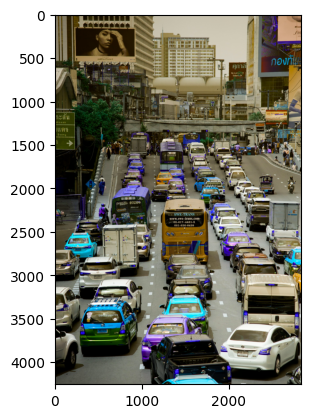

In [5]:
plt.imshow(image)

In [8]:
# box, label, count = cv.detect_common_objects(image)
# output = draw_bbox(image, box, label, count)

import os
import shutil
import requests
import cv2
import numpy as np
import matplotlib.pyplot as plt
from cvlib.object_detection import draw_bbox

# Define the paths to the cached files
cvlib_cache_dir = os.path.expanduser('~/.cvlib')

# Ensure the cache directory exists
os.makedirs(cvlib_cache_dir, exist_ok=True)

yolov3_tiny_cfg_path = os.path.join(cvlib_cache_dir, 'yolov3-tiny.cfg')
yolov3_tiny_weights_path = os.path.join(cvlib_cache_dir, 'yolov3-tiny.weights')
yolov3_classes_path = os.path.join(cvlib_cache_dir, 'yolov3_classes.txt') # Common classes file for yolov3 and yolov3-tiny

# URLs for the yolov3-tiny model files
yolov3_tiny_cfg_url = 'https://github.com/pjreddie/darknet/raw/master/cfg/yolov3-tiny.cfg'
yolov3_tiny_weights_url = 'https://pjreddie.com/media/files/yolov3-tiny.weights'
yolov3_classes_url = 'https://github.com/arunponnusamy/object-detection-opencv/raw/master/yolov3.txt'

# Manually download yolov3-tiny.cfg
if not os.path.exists(yolov3_tiny_cfg_path):
    print(f"Manually downloading {os.path.basename(yolov3_tiny_cfg_path)}...")
    response = requests.get(yolov3_tiny_cfg_url)
    response.raise_for_status() # Raise an exception for HTTP errors
    with open(yolov3_tiny_cfg_path, 'wb') as f:
        f.write(response.content)
    print(f"Downloaded {os.path.basename(yolov3_tiny_cfg_path)} to {cvlib_cache_dir}")
else:
    print(f"{os.path.basename(yolov3_tiny_cfg_path)} already exists.")

# Manually download yolov3-tiny.weights (this file is large and may take time)
if not os.path.exists(yolov3_tiny_weights_path):
    print(f"Manually downloading {os.path.basename(yolov3_tiny_weights_path)} (this may take a while)...")
    response = requests.get(yolov3_tiny_weights_url, stream=True)
    response.raise_for_status() # Raise an exception for HTTP errors
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024 # 1 Kibibyte
    downloaded_size = 0
    with open(yolov3_tiny_weights_path, 'wb') as f:
        for data in response.iter_content(block_size):
            f.write(data)
            downloaded_size += len(data)
            # Basic progress indication
            if total_size > 0:
                progress = (downloaded_size / total_size) * 100
                print(f"\rDownloading: {progress:.2f}%", end='', flush=True)
    print(f"\nDownloaded {os.path.basename(yolov3_tiny_weights_path)} to {cvlib_cache_dir}")
else:
    print(f"{os.path.basename(yolov3_tiny_weights_path)} already exists.")

# Manually download yolov3_classes.txt
if not os.path.exists(yolov3_classes_path):
    print(f"Manually downloading {os.path.basename(yolov3_classes_path)}...")
    response = requests.get(yolov3_classes_url)
    response.raise_for_status() # Raise an exception for HTTP errors
    with open(yolov3_classes_path, 'wb') as f:
        f.write(response.content)
    print(f"Downloaded {os.path.basename(yolov3_classes_path)} to {cvlib_cache_dir}")
else:
    print(f"{os.path.basename(yolov3_classes_path)} already exists.")

# --- Manual object detection using OpenCV DNN module --- 
# Load class names
with open(yolov3_classes_path, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# Load the network
net = cv2.dnn.readNet(yolov3_tiny_weights_path, yolov3_tiny_cfg_path)

# Get output layer names
layer_names = net.getLayerNames()
# Correctly handle potential variations in getUnconnectedOutLayers() return type
output_layer_indices = net.getUnconnectedOutLayers()
output_layer_indices = output_layer_indices.flatten() if isinstance(output_layer_indices, np.ndarray) else [output_layer_indices]
output_layers = [layer_names[i - 1] for i in output_layer_indices if i > 0]

# Prepare input blob
height, width, _ = image.shape
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)

# Forward pass
outs = net.forward(output_layers)

# Initialize lists for detected bounding boxes, confidences, and class IDs
boxes = []
confidences = []
class_ids = []

# Process each output layer
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5: # Confidence threshold
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Apply non-maximum suppression
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4) # confidence threshold, NMS threshold

# Filter results and prepare for draw_bbox
final_boxes = []
final_labels = []
final_counts = {}

if len(indexes) > 0:
    for i in indexes.flatten():
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])

        final_boxes.append([x, y, x + w, y + h]) # draw_bbox expects [x1, y1, x2, y2]
        final_labels.append(label)

        if label in final_counts:
            final_counts[label] += 1
        else:
            final_counts[label] = 1

# Use draw_bbox from cvlib to visualize the results
output = draw_bbox(image, final_boxes, final_labels, final_counts)

Manually downloading yolov3-tiny.cfg...
Downloaded yolov3-tiny.cfg to C:\Users\Muhammad Haris/.cvlib
Manually downloading yolov3-tiny.weights (this may take a while)...
Downloading: 100.00%
Downloaded yolov3-tiny.weights to C:\Users\Muhammad Haris/.cvlib
Manually downloading yolov3_classes.txt...
Downloaded yolov3_classes.txt to C:\Users\Muhammad Haris/.cvlib


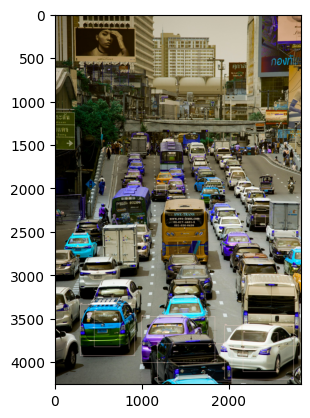

In [9]:
plt.imshow(output)

In [19]:
label.count('car')

0